In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/figshare-dataset.zip

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim import lr_scheduler

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torchvision.transforms import Compose, ToTensor
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.metrics import f1_score, precision_score, recall_score

# Set random seed for reproducibility
torch.random.seed()

17568851005252662526

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio('figshare-dataset', output = 'figshare-split' , seed = 1337, ratio = (0.7,0.1,0.2))

Copying files: 3064 files [00:00, 5641.77 files/s]


In [ ]:
train_path = 'figshare-split/train'
val_path = 'figshare-split/val'
test_path = 'figshare-split/test'

In [ ]:
transform = transforms.Compose(
    [
     transforms.Resize((224,224)),
     transforms.ToTensor()
    ]
)

In [ ]:
image_datasets = {x: torchvision.datasets.ImageFolder(eval(f"{x}_path"), transform) for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'val','test']}

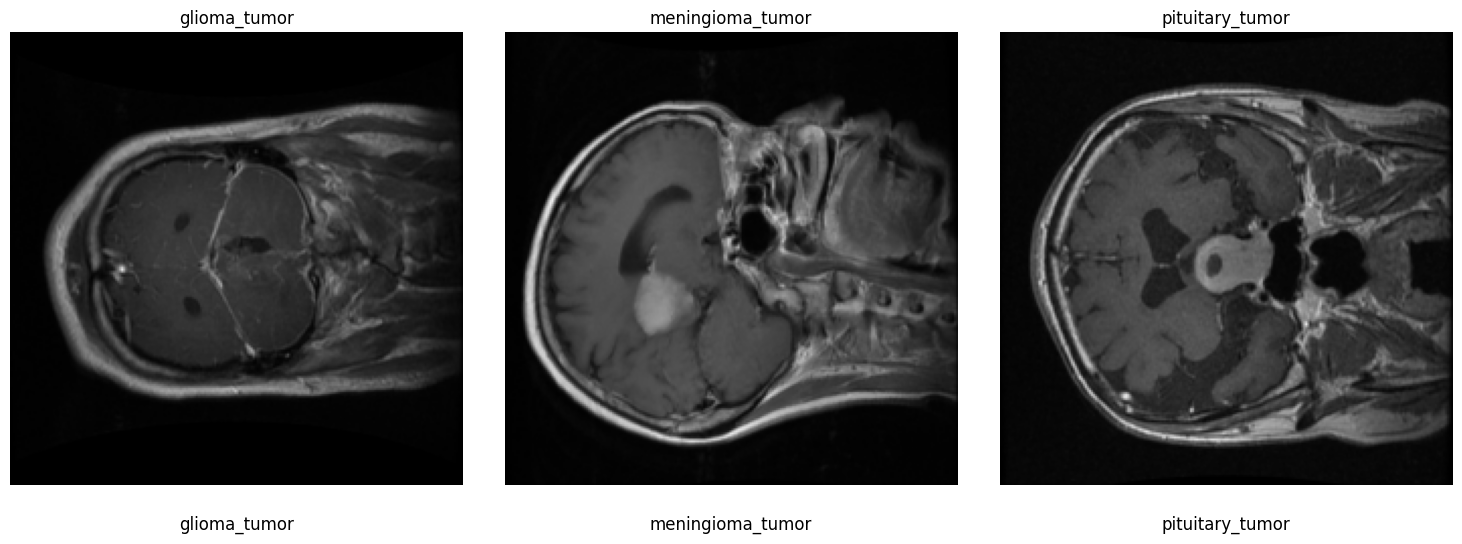

In [ ]:
def visualize_class_samples(dataset):
    classes = dataset.classes

    # Create a figure with subplots
    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

    # Loop through each class
    for i, cls in enumerate(classes):
        indices = np.where(np.array(dataset.targets) == i)[0]  # Indices of samples in this class
        selected_idx = np.random.choice(indices, size=1, replace=False)[0]  # Choose one image index

        image, _ = dataset[selected_idx]
        ax = axes[i]
        ax.imshow(np.transpose(image.numpy(), (1, 2, 0)))  # Transpose to (H, W, C)
        ax.set_title(cls)
        ax.axis('off')

        ax.text(0.5, -0.1, cls, transform=ax.transAxes, fontsize=12, ha='center')

    plt.tight_layout()
    plt.show()

visualize_class_samples(image_datasets['train'])

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=9964b98978b14aab20061e0da3858ff85b5ede807bcc97831b825e2df78f4360
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


In [ ]:
model._dropout = nn.Dropout(0.5)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

In [ ]:
train_loader = dataloaders['train']
val_loader = dataloaders['val']

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
num_epochs = 20
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate training accuracy
    model.eval()
    all_preds_train = []
    all_labels_train = []

    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_preds_train.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels_train.extend(labels.cpu().numpy())

    train_accuracy = accuracy_score(all_labels_train, all_preds_train)
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    all_preds_val = []
    all_labels_val = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            all_preds_val.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels_val.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_accuracy = accuracy_score(all_labels_val, all_preds_val)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]}, Training Accuracy: {train_accuracy}, Validation Loss: {val_losses[-1]}, Validation Accuracy: {val_accuracy}")


Epoch 1/20, Training Loss: 0.797103956119338, Training Accuracy: 0.4841417910447761, Validation Loss: 1.002176421880722, Validation Accuracy: 0.4786885245901639
Epoch 2/20, Training Loss: 0.3714948908161761, Training Accuracy: 0.5214552238805971, Validation Loss: 0.8864106476306916, Validation Accuracy: 0.5147540983606558
Epoch 3/20, Training Loss: 0.21145910213687527, Training Accuracy: 0.7495335820895522, Validation Loss: 0.620915412902832, Validation Accuracy: 0.7213114754098361
Epoch 4/20, Training Loss: 0.15185192622133156, Training Accuracy: 0.8367537313432836, Validation Loss: 0.514884889125824, Validation Accuracy: 0.8327868852459016
Epoch 5/20, Training Loss: 0.10387380145934981, Training Accuracy: 0.8689365671641791, Validation Loss: 0.4629854768514633, Validation Accuracy: 0.8557377049180328
Epoch 6/20, Training Loss: 0.09011457629724225, Training Accuracy: 0.8885261194029851, Validation Loss: 0.40741037428379057, Validation Accuracy: 0.8655737704918033
Epoch 7/20, Training 

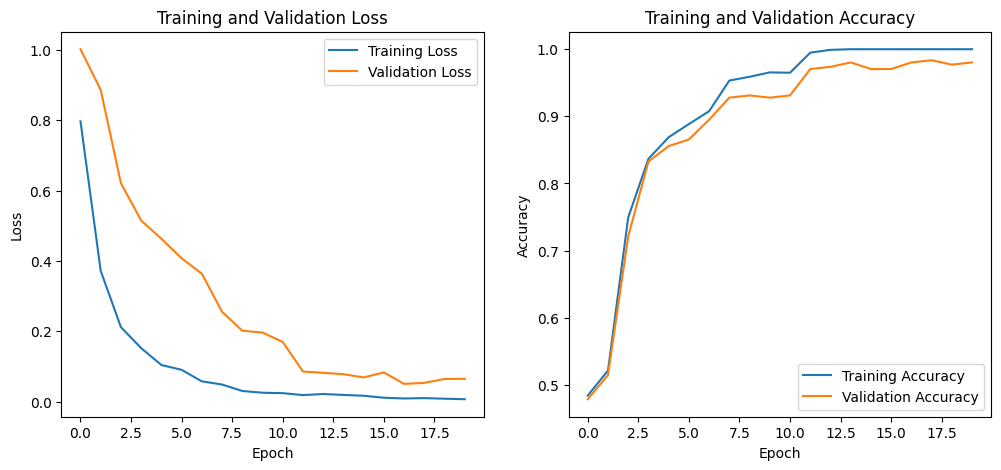

In [ ]:
plt.figure(figsize=(12, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
test_loader = dataloaders['test']

In [ ]:
model.eval()
all_preds_test = []
all_labels_test = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_preds_test.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(all_labels_test, all_preds_test)
print(f"Test Accuracy: {test_accuracy}")

# Print classification report for test set
print("Classification Report:")
print(classification_report(all_labels_test, all_preds_test))

Test Accuracy: 0.959349593495935
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       286
           1       0.95      0.88      0.92       143
           2       0.98      0.97      0.98       186

    accuracy                           0.96       615
   macro avg       0.96      0.95      0.95       615
weighted avg       0.96      0.96      0.96       615



In [ ]:
def predict_class(image_path):
    # Load an image
    image = Image.open(image_path).convert('RGB')


    # Preprocess the image
    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0).to(device)  # Move the input tensor to the appropriate device

    # Perform prediction
    with torch.no_grad():
        output = model(input_batch)

    # Get the predicted class
    _, predicted_class = torch.max(output, 1)

    return predicted_class.item()


In [ ]:
image_path = '/content/figshare-split/train/meningioma_tumor/186.png'  # Replace with the actual image path
predicted_class = predict_class(image_path)

class_names = ['Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']

print(f'Predicted Class: {class_names[predicted_class]}')

Predicted Class: Meningioma Tumor


In [ ]:
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {num_trainable_params}')

Number of trainable parameters: 4011391


In [ ]:
!pip install grad-cam

In [ ]:
print(model)

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

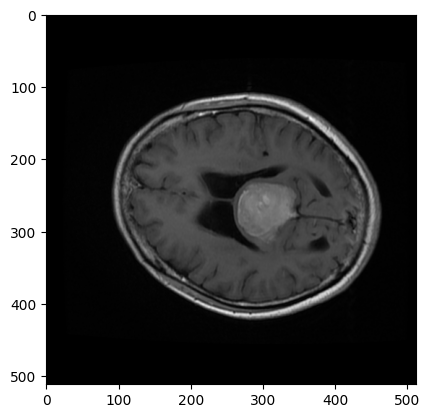

In [ ]:
image_path = '/content/figshare-split/train/meningioma_tumor/23.png'  # Replace with the actual image path
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
plt.show()


In [ ]:
input_tensor = preprocess(image)
input_tensor.unsqueeze_(0)  # Add batch dimension
input_tensor = input_tensor.float()  # Ensure the data type is float
input_tensor /= input_tensor.max()  # Normalize the data to [0,1]
input_tensor = input_tensor.to(device)

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
target_layers = [model._conv_head]

In [ ]:
print(target_layers)

[Conv2dStaticSamePadding(
  320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False
  (static_padding): Identity()
)]


In [ ]:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

In [ ]:
targets = [ClassifierOutputTarget(1)] #class label

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

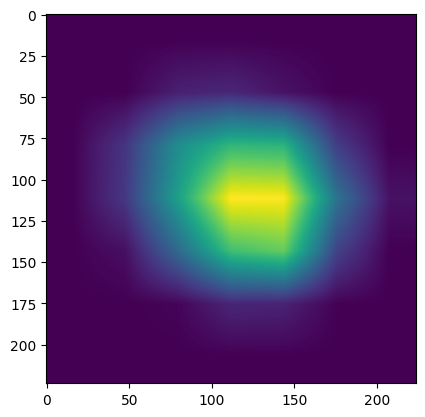

In [ ]:
plt.imshow(grayscale_cam)

In [ ]:
import cv2

In [ ]:
image_array = np.array(image)/255

In [ ]:
resized_heatmap = cv2.resize(grayscale_cam, (image_array.shape[1], image_array.shape[0]))

In [ ]:
visualization = show_cam_on_image(image_array, resized_heatmap, use_rgb=True)

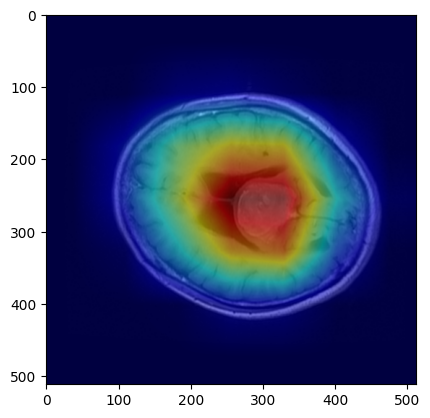

In [ ]:
plt.imshow(visualization)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model.pth')